In [1]:
import os
from os import listdir
from os.path import isfile, join
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.color import rgba2rgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

# Auxilary Functions
## retrieveAllImages()

***Summary:***

* Returns a list of all the files in a directory, our usage will simply be to retrieve the images

***Parameters:***
                    
* directory (str): Name of the directory being loaded into a list, the default is './garbage bins'

***Returns:***
                    
* fileNames (str[]): list of all the filenames in the directory passed or defaulted value

## returnImageArray()

***Summary:***

* Returns a list of all the files in a directory, our usage will simply be to retrieve the images

***Parameters:***
                    
* filename (str): Name of the file being located
                    
* directory (str): Name of the directory being loaded into a list, the default is './garbage bins'

***Returns:***
                    
* fileNames (str[]): list of all the filenames in the directory passed or defaulted value

## processImageFeatures()

***Summary:***

* Returns a list of the image's features, it tries to flatten the information into a single array instead of multiple 

***Parameters:***
                    
* image (np.array): We feed in the array that we generate using returnImageArray()

***Returns:***
                    
* flatify (np.hstack): gives us the single dimension list describing the image in grayscale

## getHOG()

***Summary:***

* Returns a histogram of gradient directions that can be previewed in jupyter

***Parameters:***
                    
* image (np.array): We feed in the array that we generate using returnImageArray()

***Returns:***
                    
* grayHOG (skimage.feature.hog): Returns the HOG describing the image, it specifically returns a multi-dimensional array

## returnClassification()

***Summary:***

* Returns the values of the image set we're training a model for.

***Parameters:***
                    
* N/A

***Returns:***
                    
* arr (int[]): Returns a list consisting of 400 "0"s and 1000 "1"s, the "0" represent everything that ISN'T a garbage bin while the "1" represents everything that IS a garbage bin. I could have simply had a csv that listed all of the filenames and their associated classification but I didn't realize until later that I needed 2 classes even if I were just testing for one. There are ways to test for only one class without needing another image set but this solution was a pretty decent bandaid.

## massRenamer()

***Summary:***

* A small utility function for renaming all of the images from the Food-5k set that I'm using. The Food-5k set specifically isn't importing the food portion of the set but everything that ISN'T food.

***Parameters:***
                    
* directory (str): Name of the directory being loaded into a list, the default is './not garbage bins/'

***Returns:***
                    
* Void: It doesn't "return" anything but helps rename everything in a directory.

In [2]:
def retrieveAllImages(directory = "./garbage and not"): 
    fileNames = [f for f in listdir(directory) if isfile(join(directory, f))]
    return fileNames

def returnImageArray(filename, directory = "./garbage and not/"):
    filePath = os.path.join(directory, filename)
    image = Image.open(filePath)
    return np.array(image)

def processImageFeatures(image):
    features = image.flatten()
    grayscaleConversion = rgb2gray(rgba2rgb(image))
    hogify = hog(grayscaleConversion, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    flatify = np.hstack(features)
    return flatify

def getHOG(image):
    grayscaleConversion = rgb2gray(rgba2rgb(image))
    features, grayHOG = hog(grayscaleConversion,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
    return grayHOG
    
def returnClassification():
    arr = []
    for i in range(400):
        arr.append(0)
    
    for i in range(1000):
        arr.append(1)
    return arr

def massRenamer(directory = './not garbage bins/'):
    numer = 1001
    for count, filename in enumerate(os.listdir(directory)):
        dst ="Screenshot_" + str(numer) + "_result.png"
        src =directory + filename
        dst =directory + dst
        os.rename(src, dst)
        numer = numer + 1

In [3]:
arr = returnClassification()

1400


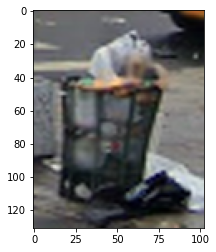

[ 95  96  99 ... 131 128 255]


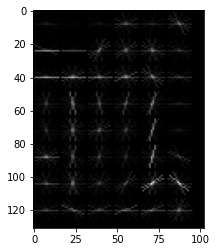

In [4]:
#fileNamesNotGarbage = retrieveAllImages('./not garbage bins/')
fileNames = retrieveAllImages()
print(len(fileNames))
test = returnImageArray(fileNames[480])
plt.imshow(test)
plt.show()

hogRow = processImageFeatures(test)
hogImage = getHOG(test)

print(hogRow)
plt.imshow(hogImage, cmap=mpl.cm.gray)

In [5]:
allFeatures = []
for file in fileNames:
    image = returnImageArray(file)
    feat = processImageFeatures(image)
    allFeatures.append(feat)
    
allFeaturesArray = np.array(allFeatures)

In [6]:
print(allFeaturesArray.shape)
reshapedF = np.stack(allFeaturesArray)
print(reshapedF.shape)
print(reshapedF[1])
scaler = StandardScaler()

garbage = scaler.fit_transform(reshapedF)

pca = PCA(n_components=100)
garbagePCA = scaler.fit_transform(garbage)

print(garbagePCA.shape)
print(pca)

(1400, 53972)
(1400, 53972)
[178 132 139 ... 211 174 255]
(1400, 53972)
PCA(n_components=100)


In [7]:
xSet = pd.DataFrame(garbagePCA)

ySet = pd.Series(list(arr))

X_train, X_test, y_train, y_test = train_test_split(xSet,
                                                    ySet,
                                                    test_size=.2,
                                                    random_state=10)


In [8]:
svm = SVC(kernel='linear', probability=True, random_state=42)

svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [9]:
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7642857142857142


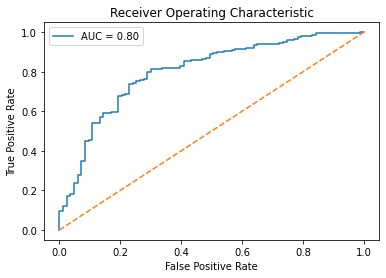

In [10]:

probabilities = svm.predict_proba(X_test)
y_proba = probabilities[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')

roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');